# LSTM - Is Solved? 

Can we use an LSTM to determine if a given scramble + solve sequence will produce a solved cube? 

Short answer - no. 

In [9]:
import datasets
from transformers import PreTrainedTokenizerFast

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from sklearn.metrics import classification_report

import numpy as np

import warnings

warnings.filterwarnings("ignore")

BATCH_SIZE = 64

device = torch.device("mps")

dataset = datasets.load_from_disk("../rubiks-is-solved-dataset")
tokenizer = PreTrainedTokenizerFast.from_pretrained("../rubiks-tokenizer")

In [10]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Model, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            self.input_size, self.hidden_size, self.num_layers, batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size, 2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        z = self.fc(out[:, -1, :])
        return z


In [11]:
from torch.utils.data import Dataset, DataLoader


class Dataset(Dataset):
    def __init__(self, samples, tokenizer, max_length=None):
        self.data = samples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        sample = self.data[idx]
        if self.max_length is None:
            tokenized_sample = self.tokenizer(
                text=" ".join(sample["scramble"]),
                text_pair=" ".join(sample["solve"]),
            )
        else:
            tokenized_sample = self.tokenizer(
                text=" ".join(sample["scramble"]),
                text_pair=" ".join(sample["solve"]),
                padding="max_length",
                max_length=self.max_length,
            )

        example_X = torch.vstack(
            [
                torch.tensor(tokenized_sample["input_ids"]),
                torch.tensor(tokenized_sample["token_type_ids"]),
                torch.tensor(tokenized_sample["attention_mask"]),
            ]
        ).T

        return example_X.to(torch.float32), sample["is_solved"]


In [12]:
train = Dataset(dataset["train"], tokenizer)
test = Dataset(dataset["test"], tokenizer)

max_length = max([s[0].shape[0] for ds in [train, test] for s in ds])

train.max_length = max_length
test.max_length = max_length

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
def test():
    model.eval()
    predicted = []
    actual = []
    history = []

    for X, y in tqdm(
        test_loader, leave=False, desc=f"Test epoch {epoch+1:02}/{EPOCHS}"
    ):
        actual.extend(y)
        y = F.one_hot(y, 2).to(torch.float32).to(device)
        X = X.to(device)

        with torch.no_grad():
            y_hat = model(X)

        loss = criterion(y_hat, y)
        history.append(loss)
        predicted.extend(y_hat.argmax(dim=-1).tolist())

    predicted = np.array(predicted)
    actual = np.array(actual)
    test_loss_history.append(sum(history) / len(history))
    classification_history.append(
        classification_report(actual, predicted, output_dict=True)
    )
    model.train()


def train():
    for X, y in tqdm(
        train_loader, leave=False, desc=f"Train epoch {epoch+1:02}/{EPOCHS}"
    ):
        y = F.one_hot(y, 2).to(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss_history.append(loss)
        loss.backward()

        optimizer.step()


model = Model(3, 64, 3)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters())

loss_history = []
test_loss_history = []
classification_history = []

EPOCHS = 20

for epoch in range(EPOCHS):
    train()
    test()

Text(0.5, 1.0, 'Train Loss')

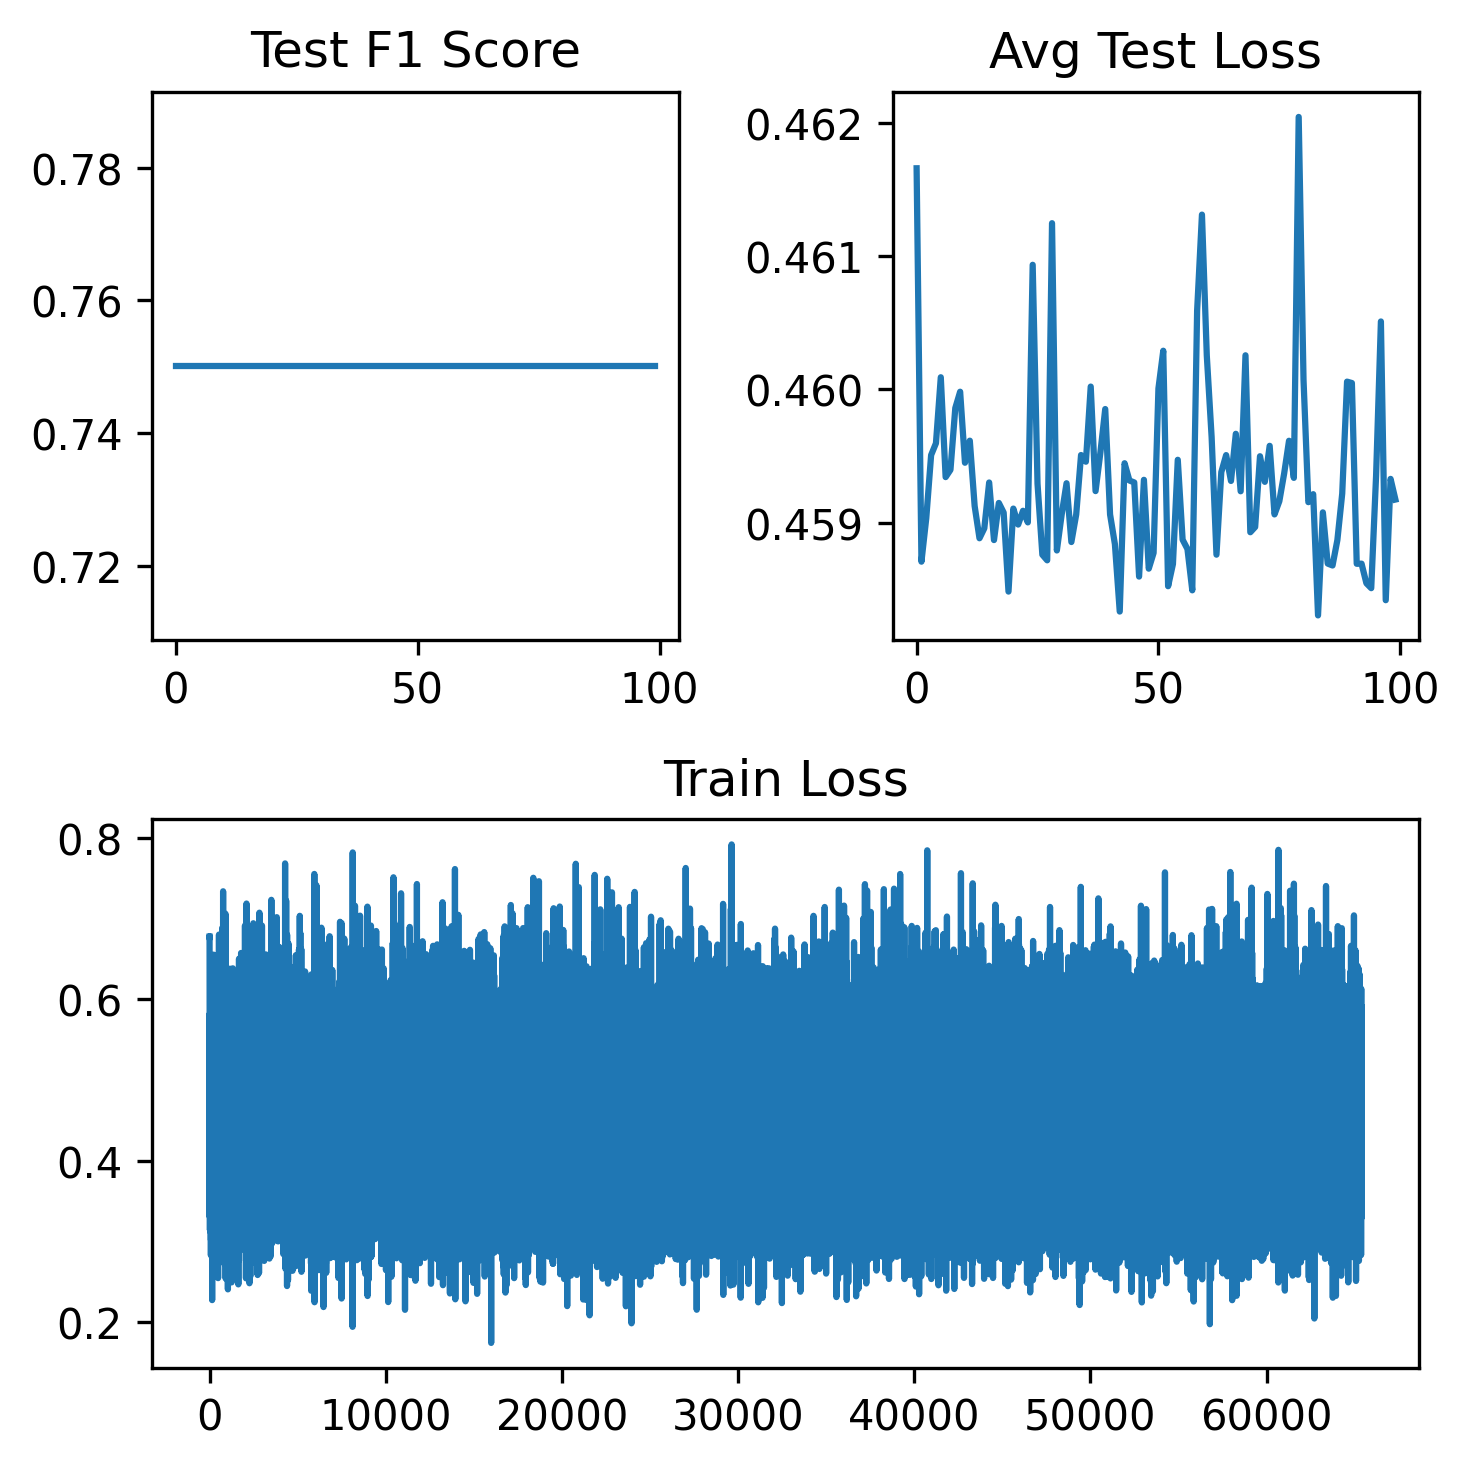

In [6]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, dpi=300, figsize=(5, 5))

fig.set_tight_layout(True)

axs[0, 0].plot([r["weighted avg"]["f1-score"] for r in classification_history])
axs[0, 0].set_title("Test F1 Score")

axs[0, 1].plot(torch.tensor(test_loss_history))
axs[0, 1].set_title("Avg Test Loss")

gs = axs[0, 0].get_gridspec()
for ax in axs[1, :]:
    ax.remove()
ax = fig.add_subplot(gs[1, :])
ax.plot(torch.tensor(loss_history).cpu())
ax.set_title("Train Loss")